##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recurrent Neural Networks (RNN) with Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/keras-team/keras-io/blob/master/tf/rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/working_with_rnns.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/keras-io/tf/rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

Recurrent neural networks (RNN) are a class of neural networks that is powerful for
modeling sequence data such as time series or natural language.

Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a
sequence, while maintaining an internal state that encodes information about the
timesteps it has seen so far.

The Keras RNN API is designed with a focus on:

- **Ease of use**: the built-in `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` layers enable you to quickly build recurrent models without
having to make difficult configuration choices.

- **Ease of customization**: You can also define your own RNN cell layer (the inner
part of the `for` loop) with custom behavior, and use it with the generic
`keras.layers.RNN` layer (the `for` loop itself). This allows you to quickly
prototype different research ideas in a flexible way with minimal code.

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Built-in RNN layers: a simple example

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations of LSTM
and GRU.

Here is a simple example of a `Sequential` model that processes sequences of integers,
embeds each integer into a 64-dimensional vector, then processes the sequence of
vectors using a `LSTM` layer.

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards` argument
- Loop unrolling (which can lead to a large speedup when processing short sequences on
CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contain a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In addition, a RNN layer can return its final internal state(s). The returned states
can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the
encoder-decoder sequence-to-sequence model, where the encoder final state is used as
the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state` parameter
to `True` when creating the layer. Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

## RNN layers and RNN cells

In addition to the built-in RNN layers, the RNN API also provides cell-level APIs.
Unlike RNN layers, which processes whole batches of input sequences, the RNN cell only
processes a single timestep.

The cell is the inside of the `for` loop of a RNN layer. Wrapping a cell inside a
`keras.layers.RNN` layer gives you a layer capable of processing batches of
sequences, e.g. `RNN(LSTMCell(10))`.

Mathematically, `RNN(LSTMCell(10))` produces the same result as `LSTM(10)`. In fact,
the implementation of this layer in TF v1.x was just creating the corresponding RNN
cell and wrapping it in a RNN layer.  However using the built-in `GRU` and `LSTM`
layers enables the use of CuDNN and you may see better performance.

There are three built-in RNN cells, each of them corresponding to the matching RNN
layer.

- `keras.layers.SimpleRNNCell` corresponds to the `SimpleRNN` layer.

- `keras.layers.GRUCell` corresponds to the `GRU` layer.

- `keras.layers.LSTMCell` corresponds to the `LSTM` layer.

The cell abstraction, together with the generic `keras.layers.RNN` class, make it
very easy to implement custom RNN architectures for your research.

## Cross-batch statefulness

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

Normally, the internal state of a RNN layer is reset every time it sees a new batch
(i.e. every sample seen by the layer is assume to be independent from the past). The
layer will only maintain a state while processing a given sample.

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer without
resetting the layer's state. That way, the layer can retain information about the
entirety of the sequence, even though it's only seeing one sub-sequence at a time.

You can do this by setting `stateful=True` in the constructor.

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into e.g.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.


> Note: In this setup, sample `i` in a given batch is assumed to be the continuation of
sample `i` in the previous batch. This means that all batches should contain the same
number of samples (batch size). E.g. if a batch contains `[sequence_A_from_t0_to_t100,
 sequence_B_from_t0_to_t100]`, the next batch should contain
`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.




Here is a complete example:

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN State Reuse
<a id="rnn_state_reuse"></a>

The recorded states of the RNN layer are not included in the `layer.weights()`. If you
would like to reuse the state from a RNN layer, you can retrieve the states value by
`layer.states` and use it as the
initial state for a new layer via the Keras functional API like `new_layer(inputs,
initial_state=layer.states)`, or model subclassing.

Please also note that sequential model might not be used in this case since it only
supports layers with single input and output, the extra input of initial state makes
it impossible to use here.

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the inputs in
reverse order.

The output of the `Bidirectional` RNN will be, by default, the sum of the forward layer
output and the backward layer output. If you need a different merging behavior, e.g.
concatenation, change the `merge_mode` parameter in the `Bidirectional` wrapper
constructor. For more details about `Bidirectional`, please check
[the API docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/).

## Performance optimization and CuDNN kernels

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN
kernels by default when a GPU is available. With this change, the prior
`keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you can build your
model without worrying about the hardware it will run on.

Since the CuDNN kernel is built with certain assumptions, this means the layer **will
not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or
GRU layers**. E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner
`tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask
corresponds to strictly right padded data, CuDNN can still be used. This is the most
common case).

For the detailed list of constraints, please see the documentation for the
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) and
[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) layers.

### Using CuDNN kernels when available

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each row of
pixels as a timestep), and we'll predict the digit's label.

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Let's load the MNIST dataset:

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

Let's create a model instance and train it.

We choose `sparse_categorical_crossentropy` as the loss function for the model. The
output of the model has shape of `[batch_size, 10]`. The target for the model is a
integer vector, each of the integer is in the range of 0 to 9.

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 0s - loss: 2.6436 - accuracy: 0.1250

 13/938 [..............................] - ETA: 3s - loss: 2.3913 - accuracy: 0.1911

 25/938 [..............................] - ETA: 3s - loss: 2.2142 - accuracy: 0.2306

 38/938 [>.............................] - ETA: 3s - loss: 2.0926 - accuracy: 0.2726

 51/938 [>.............................] - ETA: 3s - loss: 2.0000 - accuracy: 0.3110

 64/938 [=>............................] - ETA: 3s - loss: 1.9310 - accuracy: 0.3401

 77/938 [=>............................] - ETA: 3s - loss: 1.8777 - accuracy: 0.3653

 90/938 [=>............................] - ETA: 3s - loss: 1.8266 - accuracy: 0.3856

103/938 [==>...........................] - ETA: 3s - loss: 1.7904 - accuracy: 0.4009

115/938 [==>...........................] - ETA: 3s - loss: 1.7597 - accuracy: 0.4103

127/938 [===>..........................] - ETA: 3s - loss: 1.7206 - accuracy: 0.4256

140/938 [===>..........................] - ETA: 3s - loss: 1.6898 - accuracy: 0.4382

153/938 [===>..........................] - ETA: 3s - loss: 1.6616 - accuracy: 0.4489

165/938 [====>.........................] - ETA: 3s - loss: 1.6322 - accuracy: 0.4597

178/938 [====>.........................] - ETA: 3s - loss: 1.6059 - accuracy: 0.4700

191/938 [=====>........................] - ETA: 3s - loss: 1.5814 - accuracy: 0.4793

204/938 [=====>........................] - ETA: 2s - loss: 1.5585 - accuracy: 0.4877

217/938 [=====>........................] - ETA: 2s - loss: 1.5391 - accuracy: 0.4939

230/938 [======>.......................] - ETA: 2s - loss: 1.5162 - accuracy: 0.5012

243/938 [======>.......................] - ETA: 2s - loss: 1.4974 - accuracy: 0.5074

256/938 [=======>......................] - ETA: 2s - loss: 1.4790 - accuracy: 0.5136

269/938 [=======>......................] - ETA: 2s - loss: 1.4601 - accuracy: 0.5205

281/938 [=======>......................] - ETA: 2s - loss: 1.4442 - accuracy: 0.5260

293/938 [========>.....................] - ETA: 2s - loss: 1.4264 - accuracy: 0.5320

305/938 [========>.....................] - ETA: 2s - loss: 1.4131 - accuracy: 0.5365

318/938 [=========>....................] - ETA: 2s - loss: 1.3956 - accuracy: 0.5420

331/938 [=========>....................] - ETA: 2s - loss: 1.3783 - accuracy: 0.5480

344/938 [==========>...................] - ETA: 2s - loss: 1.3646 - accuracy: 0.5531

357/938 [==========>...................] - ETA: 2s - loss: 1.3504 - accuracy: 0.5586

370/938 [==========>...................] - ETA: 2s - loss: 1.3361 - accuracy: 0.5635

383/938 [===========>..................] - ETA: 2s - loss: 1.3226 - accuracy: 0.5686

395/938 [===========>..................] - ETA: 2s - loss: 1.3118 - accuracy: 0.5725

408/938 [============>.................] - ETA: 2s - loss: 1.2987 - accuracy: 0.5769

421/938 [============>.................] - ETA: 2s - loss: 1.2849 - accuracy: 0.5816

434/938 [============>.................] - ETA: 2s - loss: 1.2728 - accuracy: 0.5858

447/938 [=============>................] - ETA: 2s - loss: 1.2612 - accuracy: 0.5899

460/938 [=============>................] - ETA: 1s - loss: 1.2502 - accuracy: 0.5942

473/938 [==============>...............] - ETA: 1s - loss: 1.2406 - accuracy: 0.5974

485/938 [==============>...............] - ETA: 1s - loss: 1.2303 - accuracy: 0.6006

497/938 [==============>...............] - ETA: 1s - loss: 1.2189 - accuracy: 0.6050

510/938 [===============>..............] - ETA: 1s - loss: 1.2083 - accuracy: 0.6083

522/938 [===============>..............] - ETA: 1s - loss: 1.1989 - accuracy: 0.6118

535/938 [================>.............] - ETA: 1s - loss: 1.1886 - accuracy: 0.6154

548/938 [================>.............] - ETA: 1s - loss: 1.1782 - accuracy: 0.6188

561/938 [================>.............] - ETA: 1s - loss: 1.1672 - accuracy: 0.6227

574/938 [=================>............] - ETA: 1s - loss: 1.1579 - accuracy: 0.6260

586/938 [=================>............] - ETA: 1s - loss: 1.1492 - accuracy: 0.6289

598/938 [==================>...........] - ETA: 1s - loss: 1.1416 - accuracy: 0.6315

610/938 [==================>...........] - ETA: 1s - loss: 1.1327 - accuracy: 0.6346

623/938 [==================>...........] - ETA: 1s - loss: 1.1232 - accuracy: 0.6376

636/938 [===================>..........] - ETA: 1s - loss: 1.1134 - accuracy: 0.6412

648/938 [===================>..........] - ETA: 1s - loss: 1.1058 - accuracy: 0.6436

661/938 [====================>.........] - ETA: 1s - loss: 1.0970 - accuracy: 0.6467

673/938 [====================>.........] - ETA: 1s - loss: 1.0900 - accuracy: 0.6489

685/938 [====================>.........] - ETA: 1s - loss: 1.0825 - accuracy: 0.6514

697/938 [=====================>........] - ETA: 0s - loss: 1.0751 - accuracy: 0.6540

709/938 [=====================>........] - ETA: 0s - loss: 1.0668 - accuracy: 0.6568

721/938 [======================>.......] - ETA: 0s - loss: 1.0597 - accuracy: 0.6593

733/938 [======================>.......] - ETA: 0s - loss: 1.0525 - accuracy: 0.6621

746/938 [======================>.......] - ETA: 0s - loss: 1.0454 - accuracy: 0.6648

759/938 [=======================>......] - ETA: 0s - loss: 1.0393 - accuracy: 0.6669

772/938 [=======================>......] - ETA: 0s - loss: 1.0311 - accuracy: 0.6699

785/938 [========================>.....] - ETA: 0s - loss: 1.0244 - accuracy: 0.6721

798/938 [========================>.....] - ETA: 0s - loss: 1.0168 - accuracy: 0.6747

811/938 [========================>.....] - ETA: 0s - loss: 1.0101 - accuracy: 0.6767

824/938 [=========================>....] - ETA: 0s - loss: 1.0033 - accuracy: 0.6792

836/938 [=========================>....] - ETA: 0s - loss: 0.9976 - accuracy: 0.6812

849/938 [==========================>...] - ETA: 0s - loss: 0.9908 - accuracy: 0.6833

861/938 [==========================>...] - ETA: 0s - loss: 0.9846 - accuracy: 0.6855

874/938 [==========================>...] - ETA: 0s - loss: 0.9782 - accuracy: 0.6878

887/938 [===========================>..] - ETA: 0s - loss: 0.9717 - accuracy: 0.6901

900/938 [===========================>..] - ETA: 0s - loss: 0.9652 - accuracy: 0.6922

913/938 [============================>.] - ETA: 0s - loss: 0.9586 - accuracy: 0.6944

926/938 [============================>.] - ETA: 0s - loss: 0.9527 - accuracy: 0.6964

938/938 [==============================] - 5s 5ms/step - loss: 0.9479 - accuracy: 0.6979 - val_loss: 0.5026 - val_accuracy: 0.8424


Now, let's compare to a model that does not use the CuDNN kernel:

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 0s - loss: 0.6794 - accuracy: 0.7500

  3/938 [..............................] - ETA: 22s - loss: 0.5798 - accuracy: 0.8073

  5/938 [..............................] - ETA: 27s - loss: 0.5247 - accuracy: 0.8281

  7/938 [..............................] - ETA: 29s - loss: 0.5197 - accuracy: 0.8348

  9/938 [..............................] - ETA: 30s - loss: 0.5006 - accuracy: 0.8455

 11/938 [..............................] - ETA: 30s - loss: 0.5305 - accuracy: 0.8352

 13/938 [..............................] - ETA: 30s - loss: 0.5245 - accuracy: 0.8450

 15/938 [..............................] - ETA: 31s - loss: 0.5251 - accuracy: 0.8417

 17/938 [..............................] - ETA: 31s - loss: 0.5183 - accuracy: 0.8419

 19/938 [..............................] - ETA: 31s - loss: 0.5207 - accuracy: 0.8413

 21/938 [..............................] - ETA: 31s - loss: 0.5210 - accuracy: 0.8393

 23/938 [..............................] - ETA: 31s - loss: 0.5154 - accuracy: 0.8417

 25/938 [..............................] - ETA: 31s - loss: 0.5096 - accuracy: 0.8406

 27/938 [..............................] - ETA: 31s - loss: 0.5108 - accuracy: 0.8403

 29/938 [..............................] - ETA: 31s - loss: 0.5136 - accuracy: 0.8416

 31/938 [..............................] - ETA: 31s - loss: 0.5158 - accuracy: 0.8402

 33/938 [>.............................] - ETA: 31s - loss: 0.5145 - accuracy: 0.8404

 35/938 [>.............................] - ETA: 31s - loss: 0.5168 - accuracy: 0.8433

 37/938 [>.............................] - ETA: 31s - loss: 0.5232 - accuracy: 0.8412

 39/938 [>.............................] - ETA: 31s - loss: 0.5300 - accuracy: 0.8369

 41/938 [>.............................] - ETA: 31s - loss: 0.5287 - accuracy: 0.8377

 43/938 [>.............................] - ETA: 31s - loss: 0.5264 - accuracy: 0.8387

 45/938 [>.............................] - ETA: 31s - loss: 0.5240 - accuracy: 0.8399

 47/938 [>.............................] - ETA: 31s - loss: 0.5197 - accuracy: 0.8408

 49/938 [>.............................] - ETA: 31s - loss: 0.5194 - accuracy: 0.8396

 51/938 [>.............................] - ETA: 31s - loss: 0.5153 - accuracy: 0.8404

 53/938 [>.............................] - ETA: 31s - loss: 0.5157 - accuracy: 0.8405

 55/938 [>.............................] - ETA: 30s - loss: 0.5141 - accuracy: 0.8409

 57/938 [>.............................] - ETA: 30s - loss: 0.5093 - accuracy: 0.8424

 59/938 [>.............................] - ETA: 30s - loss: 0.5117 - accuracy: 0.8400

 61/938 [>.............................] - ETA: 30s - loss: 0.5126 - accuracy: 0.8399

 63/938 [=>............................] - ETA: 30s - loss: 0.5112 - accuracy: 0.8398

 65/938 [=>............................] - ETA: 30s - loss: 0.5161 - accuracy: 0.8389

 67/938 [=>............................] - ETA: 30s - loss: 0.5155 - accuracy: 0.8389

 69/938 [=>............................] - ETA: 30s - loss: 0.5161 - accuracy: 0.8379

 71/938 [=>............................] - ETA: 30s - loss: 0.5165 - accuracy: 0.8374

 73/938 [=>............................] - ETA: 30s - loss: 0.5184 - accuracy: 0.8360

 75/938 [=>............................] - ETA: 30s - loss: 0.5185 - accuracy: 0.8363

 77/938 [=>............................] - ETA: 30s - loss: 0.5195 - accuracy: 0.8354

 79/938 [=>............................] - ETA: 30s - loss: 0.5181 - accuracy: 0.8362

 81/938 [=>............................] - ETA: 30s - loss: 0.5182 - accuracy: 0.8366

 83/938 [=>............................] - ETA: 30s - loss: 0.5179 - accuracy: 0.8370

 85/938 [=>............................] - ETA: 30s - loss: 0.5174 - accuracy: 0.8371

 87/938 [=>............................] - ETA: 29s - loss: 0.5155 - accuracy: 0.8375

 89/938 [=>............................] - ETA: 29s - loss: 0.5180 - accuracy: 0.8364

 91/938 [=>............................] - ETA: 29s - loss: 0.5168 - accuracy: 0.8371

 93/938 [=>............................] - ETA: 29s - loss: 0.5180 - accuracy: 0.8364

 95/938 [==>...........................] - ETA: 29s - loss: 0.5161 - accuracy: 0.8368

 97/938 [==>...........................] - ETA: 29s - loss: 0.5139 - accuracy: 0.8375

 99/938 [==>...........................] - ETA: 29s - loss: 0.5147 - accuracy: 0.8376

101/938 [==>...........................] - ETA: 29s - loss: 0.5134 - accuracy: 0.8382

103/938 [==>...........................] - ETA: 29s - loss: 0.5133 - accuracy: 0.8383

105/938 [==>...........................] - ETA: 29s - loss: 0.5126 - accuracy: 0.8385

107/938 [==>...........................] - ETA: 29s - loss: 0.5114 - accuracy: 0.8389

109/938 [==>...........................] - ETA: 29s - loss: 0.5105 - accuracy: 0.8393

111/938 [==>...........................] - ETA: 29s - loss: 0.5108 - accuracy: 0.8397

113/938 [==>...........................] - ETA: 29s - loss: 0.5130 - accuracy: 0.8396

115/938 [==>...........................] - ETA: 29s - loss: 0.5124 - accuracy: 0.8397

117/938 [==>...........................] - ETA: 29s - loss: 0.5112 - accuracy: 0.8403

119/938 [==>...........................] - ETA: 29s - loss: 0.5105 - accuracy: 0.8405

121/938 [==>...........................] - ETA: 29s - loss: 0.5092 - accuracy: 0.8409

123/938 [==>...........................] - ETA: 28s - loss: 0.5108 - accuracy: 0.8406

125/938 [==>...........................] - ETA: 28s - loss: 0.5091 - accuracy: 0.8405

127/938 [===>..........................] - ETA: 28s - loss: 0.5089 - accuracy: 0.8408

129/938 [===>..........................] - ETA: 28s - loss: 0.5092 - accuracy: 0.8413

131/938 [===>..........................] - ETA: 28s - loss: 0.5080 - accuracy: 0.8418

133/938 [===>..........................] - ETA: 28s - loss: 0.5075 - accuracy: 0.8421

135/938 [===>..........................] - ETA: 28s - loss: 0.5087 - accuracy: 0.8420

137/938 [===>..........................] - ETA: 28s - loss: 0.5083 - accuracy: 0.8423

139/938 [===>..........................] - ETA: 28s - loss: 0.5070 - accuracy: 0.8426

141/938 [===>..........................] - ETA: 28s - loss: 0.5076 - accuracy: 0.8423

143/938 [===>..........................] - ETA: 28s - loss: 0.5075 - accuracy: 0.8427

145/938 [===>..........................] - ETA: 28s - loss: 0.5078 - accuracy: 0.8430

147/938 [===>..........................] - ETA: 28s - loss: 0.5060 - accuracy: 0.8439

149/938 [===>..........................] - ETA: 28s - loss: 0.5052 - accuracy: 0.8444

151/938 [===>..........................] - ETA: 28s - loss: 0.5053 - accuracy: 0.8445

153/938 [===>..........................] - ETA: 27s - loss: 0.5057 - accuracy: 0.8440

155/938 [===>..........................] - ETA: 27s - loss: 0.5048 - accuracy: 0.8443

157/938 [====>.........................] - ETA: 27s - loss: 0.5049 - accuracy: 0.8440

159/938 [====>.........................] - ETA: 27s - loss: 0.5040 - accuracy: 0.8442

161/938 [====>.........................] - ETA: 27s - loss: 0.5049 - accuracy: 0.8434

163/938 [====>.........................] - ETA: 27s - loss: 0.5031 - accuracy: 0.8442

165/938 [====>.........................] - ETA: 27s - loss: 0.5045 - accuracy: 0.8440

167/938 [====>.........................] - ETA: 27s - loss: 0.5048 - accuracy: 0.8436

169/938 [====>.........................] - ETA: 27s - loss: 0.5032 - accuracy: 0.8440

171/938 [====>.........................] - ETA: 27s - loss: 0.5017 - accuracy: 0.8445

173/938 [====>.........................] - ETA: 27s - loss: 0.5017 - accuracy: 0.8441

175/938 [====>.........................] - ETA: 27s - loss: 0.5004 - accuracy: 0.8448

177/938 [====>.........................] - ETA: 27s - loss: 0.4996 - accuracy: 0.8448

179/938 [====>.........................] - ETA: 26s - loss: 0.5002 - accuracy: 0.8447

181/938 [====>.........................] - ETA: 26s - loss: 0.4995 - accuracy: 0.8446

183/938 [====>.........................] - ETA: 26s - loss: 0.4996 - accuracy: 0.8447

185/938 [====>.........................] - ETA: 26s - loss: 0.5002 - accuracy: 0.8447

187/938 [====>.........................] - ETA: 26s - loss: 0.5006 - accuracy: 0.8447

189/938 [=====>........................] - ETA: 26s - loss: 0.5017 - accuracy: 0.8447

191/938 [=====>........................] - ETA: 26s - loss: 0.5005 - accuracy: 0.8453

193/938 [=====>........................] - ETA: 26s - loss: 0.5001 - accuracy: 0.8454

195/938 [=====>........................] - ETA: 26s - loss: 0.4990 - accuracy: 0.8458

197/938 [=====>........................] - ETA: 26s - loss: 0.4994 - accuracy: 0.8455

199/938 [=====>........................] - ETA: 26s - loss: 0.4992 - accuracy: 0.8455

201/938 [=====>........................] - ETA: 26s - loss: 0.4986 - accuracy: 0.8454

203/938 [=====>........................] - ETA: 26s - loss: 0.4993 - accuracy: 0.8451

205/938 [=====>........................] - ETA: 26s - loss: 0.4983 - accuracy: 0.8457

207/938 [=====>........................] - ETA: 26s - loss: 0.4975 - accuracy: 0.8457

209/938 [=====>........................] - ETA: 25s - loss: 0.4968 - accuracy: 0.8461

211/938 [=====>........................] - ETA: 25s - loss: 0.4963 - accuracy: 0.8462

213/938 [=====>........................] - ETA: 25s - loss: 0.4945 - accuracy: 0.8467

215/938 [=====>........................] - ETA: 25s - loss: 0.4944 - accuracy: 0.8469

217/938 [=====>........................] - ETA: 25s - loss: 0.4937 - accuracy: 0.8470

219/938 [======>.......................] - ETA: 25s - loss: 0.4938 - accuracy: 0.8468

221/938 [======>.......................] - ETA: 25s - loss: 0.4932 - accuracy: 0.8471

223/938 [======>.......................] - ETA: 25s - loss: 0.4934 - accuracy: 0.8470

225/938 [======>.......................] - ETA: 25s - loss: 0.4930 - accuracy: 0.8474

227/938 [======>.......................] - ETA: 25s - loss: 0.4924 - accuracy: 0.8476

229/938 [======>.......................] - ETA: 25s - loss: 0.4917 - accuracy: 0.8477

231/938 [======>.......................] - ETA: 25s - loss: 0.4916 - accuracy: 0.8475

233/938 [======>.......................] - ETA: 25s - loss: 0.4904 - accuracy: 0.8482

235/938 [======>.......................] - ETA: 24s - loss: 0.4912 - accuracy: 0.8477

237/938 [======>.......................] - ETA: 24s - loss: 0.4911 - accuracy: 0.8479

239/938 [======>.......................] - ETA: 24s - loss: 0.4913 - accuracy: 0.8479

241/938 [======>.......................] - ETA: 24s - loss: 0.4907 - accuracy: 0.8479

243/938 [======>.......................] - ETA: 24s - loss: 0.4903 - accuracy: 0.8479

245/938 [======>.......................] - ETA: 24s - loss: 0.4885 - accuracy: 0.8486

247/938 [======>.......................] - ETA: 24s - loss: 0.4889 - accuracy: 0.8486

249/938 [======>.......................] - ETA: 24s - loss: 0.4881 - accuracy: 0.8490

251/938 [=======>......................] - ETA: 24s - loss: 0.4885 - accuracy: 0.8489

253/938 [=======>......................] - ETA: 24s - loss: 0.4880 - accuracy: 0.8491

255/938 [=======>......................] - ETA: 24s - loss: 0.4869 - accuracy: 0.8494

257/938 [=======>......................] - ETA: 24s - loss: 0.4862 - accuracy: 0.8496

259/938 [=======>......................] - ETA: 24s - loss: 0.4859 - accuracy: 0.8499

261/938 [=======>......................] - ETA: 24s - loss: 0.4854 - accuracy: 0.8503

263/938 [=======>......................] - ETA: 24s - loss: 0.4848 - accuracy: 0.8505

265/938 [=======>......................] - ETA: 23s - loss: 0.4834 - accuracy: 0.8511

267/938 [=======>......................] - ETA: 23s - loss: 0.4832 - accuracy: 0.8512

269/938 [=======>......................] - ETA: 23s - loss: 0.4825 - accuracy: 0.8512

271/938 [=======>......................] - ETA: 23s - loss: 0.4831 - accuracy: 0.8511

273/938 [=======>......................] - ETA: 23s - loss: 0.4823 - accuracy: 0.8514

275/938 [=======>......................] - ETA: 23s - loss: 0.4807 - accuracy: 0.8522

277/938 [=======>......................] - ETA: 23s - loss: 0.4806 - accuracy: 0.8524

279/938 [=======>......................] - ETA: 23s - loss: 0.4806 - accuracy: 0.8524

281/938 [=======>......................] - ETA: 23s - loss: 0.4799 - accuracy: 0.8525

283/938 [========>.....................] - ETA: 23s - loss: 0.4800 - accuracy: 0.8529

285/938 [========>.....................] - ETA: 23s - loss: 0.4801 - accuracy: 0.8530

287/938 [========>.....................] - ETA: 23s - loss: 0.4797 - accuracy: 0.8531

289/938 [========>.....................] - ETA: 23s - loss: 0.4793 - accuracy: 0.8532

291/938 [========>.....................] - ETA: 23s - loss: 0.4781 - accuracy: 0.8535

293/938 [========>.....................] - ETA: 22s - loss: 0.4778 - accuracy: 0.8537

295/938 [========>.....................] - ETA: 22s - loss: 0.4770 - accuracy: 0.8540

297/938 [========>.....................] - ETA: 22s - loss: 0.4767 - accuracy: 0.8540

299/938 [========>.....................] - ETA: 22s - loss: 0.4763 - accuracy: 0.8540

301/938 [========>.....................] - ETA: 22s - loss: 0.4753 - accuracy: 0.8543

303/938 [========>.....................] - ETA: 22s - loss: 0.4748 - accuracy: 0.8545

305/938 [========>.....................] - ETA: 22s - loss: 0.4753 - accuracy: 0.8545

307/938 [========>.....................] - ETA: 22s - loss: 0.4754 - accuracy: 0.8546

309/938 [========>.....................] - ETA: 22s - loss: 0.4747 - accuracy: 0.8548

311/938 [========>.....................] - ETA: 22s - loss: 0.4745 - accuracy: 0.8550

313/938 [=========>....................] - ETA: 22s - loss: 0.4746 - accuracy: 0.8550

315/938 [=========>....................] - ETA: 22s - loss: 0.4752 - accuracy: 0.8548

317/938 [=========>....................] - ETA: 22s - loss: 0.4745 - accuracy: 0.8551

319/938 [=========>....................] - ETA: 21s - loss: 0.4741 - accuracy: 0.8551

321/938 [=========>....................] - ETA: 21s - loss: 0.4739 - accuracy: 0.8553

323/938 [=========>....................] - ETA: 21s - loss: 0.4735 - accuracy: 0.8554

325/938 [=========>....................] - ETA: 21s - loss: 0.4733 - accuracy: 0.8554

327/938 [=========>....................] - ETA: 21s - loss: 0.4728 - accuracy: 0.8555

329/938 [=========>....................] - ETA: 21s - loss: 0.4722 - accuracy: 0.8557

331/938 [=========>....................] - ETA: 21s - loss: 0.4717 - accuracy: 0.8557

333/938 [=========>....................] - ETA: 21s - loss: 0.4712 - accuracy: 0.8559

335/938 [=========>....................] - ETA: 21s - loss: 0.4708 - accuracy: 0.8561

337/938 [=========>....................] - ETA: 21s - loss: 0.4705 - accuracy: 0.8563

339/938 [=========>....................] - ETA: 21s - loss: 0.4698 - accuracy: 0.8564

341/938 [=========>....................] - ETA: 21s - loss: 0.4697 - accuracy: 0.8563

343/938 [=========>....................] - ETA: 21s - loss: 0.4694 - accuracy: 0.8562

345/938 [==========>...................] - ETA: 21s - loss: 0.4690 - accuracy: 0.8564

347/938 [==========>...................] - ETA: 20s - loss: 0.4687 - accuracy: 0.8566

349/938 [==========>...................] - ETA: 20s - loss: 0.4678 - accuracy: 0.8569

351/938 [==========>...................] - ETA: 20s - loss: 0.4677 - accuracy: 0.8569

353/938 [==========>...................] - ETA: 20s - loss: 0.4675 - accuracy: 0.8569

355/938 [==========>...................] - ETA: 20s - loss: 0.4673 - accuracy: 0.8571

357/938 [==========>...................] - ETA: 20s - loss: 0.4669 - accuracy: 0.8572

359/938 [==========>...................] - ETA: 20s - loss: 0.4667 - accuracy: 0.8573

361/938 [==========>...................] - ETA: 20s - loss: 0.4668 - accuracy: 0.8573

363/938 [==========>...................] - ETA: 20s - loss: 0.4667 - accuracy: 0.8574

365/938 [==========>...................] - ETA: 20s - loss: 0.4663 - accuracy: 0.8576

367/938 [==========>...................] - ETA: 20s - loss: 0.4658 - accuracy: 0.8574

369/938 [==========>...................] - ETA: 20s - loss: 0.4657 - accuracy: 0.8573

371/938 [==========>...................] - ETA: 20s - loss: 0.4654 - accuracy: 0.8573

373/938 [==========>...................] - ETA: 20s - loss: 0.4648 - accuracy: 0.8574

375/938 [==========>...................] - ETA: 19s - loss: 0.4645 - accuracy: 0.8575

377/938 [===========>..................] - ETA: 19s - loss: 0.4643 - accuracy: 0.8576

379/938 [===========>..................] - ETA: 19s - loss: 0.4640 - accuracy: 0.8578

381/938 [===========>..................] - ETA: 19s - loss: 0.4636 - accuracy: 0.8579

383/938 [===========>..................] - ETA: 19s - loss: 0.4636 - accuracy: 0.8579

385/938 [===========>..................] - ETA: 19s - loss: 0.4630 - accuracy: 0.8581

387/938 [===========>..................] - ETA: 19s - loss: 0.4625 - accuracy: 0.8581

389/938 [===========>..................] - ETA: 19s - loss: 0.4624 - accuracy: 0.8581

391/938 [===========>..................] - ETA: 19s - loss: 0.4626 - accuracy: 0.8579

393/938 [===========>..................] - ETA: 19s - loss: 0.4622 - accuracy: 0.8581

395/938 [===========>..................] - ETA: 19s - loss: 0.4625 - accuracy: 0.8580

397/938 [===========>..................] - ETA: 19s - loss: 0.4623 - accuracy: 0.8580

399/938 [===========>..................] - ETA: 19s - loss: 0.4627 - accuracy: 0.8578

401/938 [===========>..................] - ETA: 18s - loss: 0.4623 - accuracy: 0.8579

403/938 [===========>..................] - ETA: 18s - loss: 0.4616 - accuracy: 0.8583

405/938 [===========>..................] - ETA: 18s - loss: 0.4611 - accuracy: 0.8584

407/938 [============>.................] - ETA: 18s - loss: 0.4608 - accuracy: 0.8585

409/938 [============>.................] - ETA: 18s - loss: 0.4605 - accuracy: 0.8587

411/938 [============>.................] - ETA: 18s - loss: 0.4600 - accuracy: 0.8588

413/938 [============>.................] - ETA: 18s - loss: 0.4594 - accuracy: 0.8588

415/938 [============>.................] - ETA: 18s - loss: 0.4596 - accuracy: 0.8586

417/938 [============>.................] - ETA: 18s - loss: 0.4597 - accuracy: 0.8585

419/938 [============>.................] - ETA: 18s - loss: 0.4590 - accuracy: 0.8586

421/938 [============>.................] - ETA: 18s - loss: 0.4592 - accuracy: 0.8586

423/938 [============>.................] - ETA: 18s - loss: 0.4585 - accuracy: 0.8587

425/938 [============>.................] - ETA: 18s - loss: 0.4578 - accuracy: 0.8590

427/938 [============>.................] - ETA: 18s - loss: 0.4576 - accuracy: 0.8591

429/938 [============>.................] - ETA: 18s - loss: 0.4571 - accuracy: 0.8593

431/938 [============>.................] - ETA: 17s - loss: 0.4563 - accuracy: 0.8596

433/938 [============>.................] - ETA: 17s - loss: 0.4559 - accuracy: 0.8597

435/938 [============>.................] - ETA: 17s - loss: 0.4558 - accuracy: 0.8597

437/938 [============>.................] - ETA: 17s - loss: 0.4553 - accuracy: 0.8599

439/938 [=============>................] - ETA: 17s - loss: 0.4545 - accuracy: 0.8603

441/938 [=============>................] - ETA: 17s - loss: 0.4546 - accuracy: 0.8602

443/938 [=============>................] - ETA: 17s - loss: 0.4544 - accuracy: 0.8603

445/938 [=============>................] - ETA: 17s - loss: 0.4541 - accuracy: 0.8603

447/938 [=============>................] - ETA: 17s - loss: 0.4538 - accuracy: 0.8604

449/938 [=============>................] - ETA: 17s - loss: 0.4535 - accuracy: 0.8606

451/938 [=============>................] - ETA: 17s - loss: 0.4531 - accuracy: 0.8606

453/938 [=============>................] - ETA: 17s - loss: 0.4530 - accuracy: 0.8607

455/938 [=============>................] - ETA: 17s - loss: 0.4526 - accuracy: 0.8607

457/938 [=============>................] - ETA: 17s - loss: 0.4523 - accuracy: 0.8607

459/938 [=============>................] - ETA: 16s - loss: 0.4521 - accuracy: 0.8608

461/938 [=============>................] - ETA: 16s - loss: 0.4522 - accuracy: 0.8608

463/938 [=============>................] - ETA: 16s - loss: 0.4519 - accuracy: 0.8610

465/938 [=============>................] - ETA: 16s - loss: 0.4512 - accuracy: 0.8612

467/938 [=============>................] - ETA: 16s - loss: 0.4508 - accuracy: 0.8614

469/938 [==============>...............] - ETA: 16s - loss: 0.4506 - accuracy: 0.8614

471/938 [==============>...............] - ETA: 16s - loss: 0.4504 - accuracy: 0.8614

473/938 [==============>...............] - ETA: 16s - loss: 0.4502 - accuracy: 0.8614

475/938 [==============>...............] - ETA: 16s - loss: 0.4498 - accuracy: 0.8614

477/938 [==============>...............] - ETA: 16s - loss: 0.4497 - accuracy: 0.8612

479/938 [==============>...............] - ETA: 16s - loss: 0.4490 - accuracy: 0.8616

481/938 [==============>...............] - ETA: 16s - loss: 0.4489 - accuracy: 0.8616

483/938 [==============>...............] - ETA: 16s - loss: 0.4487 - accuracy: 0.8617

485/938 [==============>...............] - ETA: 16s - loss: 0.4487 - accuracy: 0.8618

487/938 [==============>...............] - ETA: 16s - loss: 0.4485 - accuracy: 0.8618

489/938 [==============>...............] - ETA: 15s - loss: 0.4482 - accuracy: 0.8621

491/938 [==============>...............] - ETA: 15s - loss: 0.4480 - accuracy: 0.8621

493/938 [==============>...............] - ETA: 15s - loss: 0.4474 - accuracy: 0.8623

495/938 [==============>...............] - ETA: 15s - loss: 0.4471 - accuracy: 0.8624

497/938 [==============>...............] - ETA: 15s - loss: 0.4472 - accuracy: 0.8624

499/938 [==============>...............] - ETA: 15s - loss: 0.4474 - accuracy: 0.8624

501/938 [===============>..............] - ETA: 15s - loss: 0.4474 - accuracy: 0.8625

503/938 [===============>..............] - ETA: 15s - loss: 0.4477 - accuracy: 0.8625

505/938 [===============>..............] - ETA: 15s - loss: 0.4477 - accuracy: 0.8626

507/938 [===============>..............] - ETA: 15s - loss: 0.4474 - accuracy: 0.8627

509/938 [===============>..............] - ETA: 15s - loss: 0.4468 - accuracy: 0.8629

511/938 [===============>..............] - ETA: 15s - loss: 0.4462 - accuracy: 0.8631

513/938 [===============>..............] - ETA: 15s - loss: 0.4459 - accuracy: 0.8632

515/938 [===============>..............] - ETA: 15s - loss: 0.4459 - accuracy: 0.8631

517/938 [===============>..............] - ETA: 15s - loss: 0.4454 - accuracy: 0.8632

519/938 [===============>..............] - ETA: 14s - loss: 0.4454 - accuracy: 0.8632

521/938 [===============>..............] - ETA: 14s - loss: 0.4448 - accuracy: 0.8635

523/938 [===============>..............] - ETA: 14s - loss: 0.4445 - accuracy: 0.8635

525/938 [===============>..............] - ETA: 14s - loss: 0.4444 - accuracy: 0.8636

527/938 [===============>..............] - ETA: 14s - loss: 0.4439 - accuracy: 0.8638

529/938 [===============>..............] - ETA: 14s - loss: 0.4433 - accuracy: 0.8641

531/938 [===============>..............] - ETA: 14s - loss: 0.4428 - accuracy: 0.8643

533/938 [================>.............] - ETA: 14s - loss: 0.4420 - accuracy: 0.8645

535/938 [================>.............] - ETA: 14s - loss: 0.4416 - accuracy: 0.8647

537/938 [================>.............] - ETA: 14s - loss: 0.4416 - accuracy: 0.8646

539/938 [================>.............] - ETA: 14s - loss: 0.4412 - accuracy: 0.8647

541/938 [================>.............] - ETA: 14s - loss: 0.4411 - accuracy: 0.8648

543/938 [================>.............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8648

545/938 [================>.............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8648

547/938 [================>.............] - ETA: 14s - loss: 0.4413 - accuracy: 0.8648

549/938 [================>.............] - ETA: 14s - loss: 0.4411 - accuracy: 0.8649

551/938 [================>.............] - ETA: 13s - loss: 0.4414 - accuracy: 0.8648

553/938 [================>.............] - ETA: 13s - loss: 0.4409 - accuracy: 0.8651

555/938 [================>.............] - ETA: 13s - loss: 0.4406 - accuracy: 0.8652

557/938 [================>.............] - ETA: 13s - loss: 0.4402 - accuracy: 0.8654

559/938 [================>.............] - ETA: 13s - loss: 0.4401 - accuracy: 0.8654

561/938 [================>.............] - ETA: 13s - loss: 0.4401 - accuracy: 0.8654

563/938 [=================>............] - ETA: 13s - loss: 0.4401 - accuracy: 0.8654

565/938 [=================>............] - ETA: 13s - loss: 0.4399 - accuracy: 0.8655

567/938 [=================>............] - ETA: 13s - loss: 0.4394 - accuracy: 0.8658

568/938 [=================>............] - ETA: 13s - loss: 0.4393 - accuracy: 0.8657

570/938 [=================>............] - ETA: 13s - loss: 0.4386 - accuracy: 0.8660

572/938 [=================>............] - ETA: 13s - loss: 0.4387 - accuracy: 0.8660

574/938 [=================>............] - ETA: 13s - loss: 0.4382 - accuracy: 0.8662

576/938 [=================>............] - ETA: 13s - loss: 0.4383 - accuracy: 0.8660

578/938 [=================>............] - ETA: 13s - loss: 0.4381 - accuracy: 0.8660

580/938 [=================>............] - ETA: 12s - loss: 0.4378 - accuracy: 0.8661

582/938 [=================>............] - ETA: 12s - loss: 0.4374 - accuracy: 0.8662

584/938 [=================>............] - ETA: 12s - loss: 0.4367 - accuracy: 0.8665

586/938 [=================>............] - ETA: 12s - loss: 0.4364 - accuracy: 0.8666

588/938 [=================>............] - ETA: 12s - loss: 0.4368 - accuracy: 0.8665

590/938 [=================>............] - ETA: 12s - loss: 0.4360 - accuracy: 0.8668

592/938 [=================>............] - ETA: 12s - loss: 0.4358 - accuracy: 0.8669

594/938 [=================>............] - ETA: 12s - loss: 0.4353 - accuracy: 0.8672

596/938 [==================>...........] - ETA: 12s - loss: 0.4352 - accuracy: 0.8672

598/938 [==================>...........] - ETA: 12s - loss: 0.4350 - accuracy: 0.8672

600/938 [==================>...........] - ETA: 12s - loss: 0.4345 - accuracy: 0.8674

602/938 [==================>...........] - ETA: 12s - loss: 0.4341 - accuracy: 0.8676

604/938 [==================>...........] - ETA: 12s - loss: 0.4338 - accuracy: 0.8677

606/938 [==================>...........] - ETA: 12s - loss: 0.4336 - accuracy: 0.8678

608/938 [==================>...........] - ETA: 12s - loss: 0.4336 - accuracy: 0.8678

610/938 [==================>...........] - ETA: 11s - loss: 0.4333 - accuracy: 0.8679

612/938 [==================>...........] - ETA: 11s - loss: 0.4329 - accuracy: 0.8680

614/938 [==================>...........] - ETA: 11s - loss: 0.4327 - accuracy: 0.8681

616/938 [==================>...........] - ETA: 11s - loss: 0.4324 - accuracy: 0.8683

618/938 [==================>...........] - ETA: 11s - loss: 0.4319 - accuracy: 0.8685

620/938 [==================>...........] - ETA: 11s - loss: 0.4315 - accuracy: 0.8686

622/938 [==================>...........] - ETA: 11s - loss: 0.4310 - accuracy: 0.8688

624/938 [==================>...........] - ETA: 11s - loss: 0.4304 - accuracy: 0.8690

626/938 [===================>..........] - ETA: 11s - loss: 0.4301 - accuracy: 0.8692

628/938 [===================>..........] - ETA: 11s - loss: 0.4298 - accuracy: 0.8693

630/938 [===================>..........] - ETA: 11s - loss: 0.4296 - accuracy: 0.8692

632/938 [===================>..........] - ETA: 11s - loss: 0.4293 - accuracy: 0.8693

634/938 [===================>..........] - ETA: 11s - loss: 0.4290 - accuracy: 0.8693

636/938 [===================>..........] - ETA: 11s - loss: 0.4285 - accuracy: 0.8695

638/938 [===================>..........] - ETA: 10s - loss: 0.4282 - accuracy: 0.8696

640/938 [===================>..........] - ETA: 10s - loss: 0.4281 - accuracy: 0.8697

642/938 [===================>..........] - ETA: 10s - loss: 0.4281 - accuracy: 0.8697

644/938 [===================>..........] - ETA: 10s - loss: 0.4281 - accuracy: 0.8697

646/938 [===================>..........] - ETA: 10s - loss: 0.4283 - accuracy: 0.8696

648/938 [===================>..........] - ETA: 10s - loss: 0.4280 - accuracy: 0.8697

650/938 [===================>..........] - ETA: 10s - loss: 0.4279 - accuracy: 0.8698

652/938 [===================>..........] - ETA: 10s - loss: 0.4279 - accuracy: 0.8698

654/938 [===================>..........] - ETA: 10s - loss: 0.4278 - accuracy: 0.8699

656/938 [===================>..........] - ETA: 10s - loss: 0.4272 - accuracy: 0.8700

658/938 [====================>.........] - ETA: 10s - loss: 0.4269 - accuracy: 0.8701

660/938 [====================>.........] - ETA: 10s - loss: 0.4265 - accuracy: 0.8703

662/938 [====================>.........] - ETA: 10s - loss: 0.4264 - accuracy: 0.8704

664/938 [====================>.........] - ETA: 10s - loss: 0.4262 - accuracy: 0.8703

666/938 [====================>.........] - ETA: 9s - loss: 0.4260 - accuracy: 0.8703 

668/938 [====================>.........] - ETA: 9s - loss: 0.4257 - accuracy: 0.8704

670/938 [====================>.........] - ETA: 9s - loss: 0.4254 - accuracy: 0.8704

672/938 [====================>.........] - ETA: 9s - loss: 0.4257 - accuracy: 0.8703

674/938 [====================>.........] - ETA: 9s - loss: 0.4258 - accuracy: 0.8702

676/938 [====================>.........] - ETA: 9s - loss: 0.4255 - accuracy: 0.8704

678/938 [====================>.........] - ETA: 9s - loss: 0.4250 - accuracy: 0.8706

680/938 [====================>.........] - ETA: 9s - loss: 0.4246 - accuracy: 0.8707

682/938 [====================>.........] - ETA: 9s - loss: 0.4242 - accuracy: 0.8709

684/938 [====================>.........] - ETA: 9s - loss: 0.4237 - accuracy: 0.8711

686/938 [====================>.........] - ETA: 9s - loss: 0.4234 - accuracy: 0.8711

688/938 [=====================>........] - ETA: 9s - loss: 0.4231 - accuracy: 0.8712

690/938 [=====================>........] - ETA: 9s - loss: 0.4225 - accuracy: 0.8714

692/938 [=====================>........] - ETA: 9s - loss: 0.4219 - accuracy: 0.8717

694/938 [=====================>........] - ETA: 8s - loss: 0.4217 - accuracy: 0.8718

696/938 [=====================>........] - ETA: 8s - loss: 0.4213 - accuracy: 0.8719

698/938 [=====================>........] - ETA: 8s - loss: 0.4212 - accuracy: 0.8720

700/938 [=====================>........] - ETA: 8s - loss: 0.4208 - accuracy: 0.8721

702/938 [=====================>........] - ETA: 8s - loss: 0.4209 - accuracy: 0.8722

703/938 [=====================>........] - ETA: 8s - loss: 0.4208 - accuracy: 0.8722

705/938 [=====================>........] - ETA: 8s - loss: 0.4204 - accuracy: 0.8723

707/938 [=====================>........] - ETA: 8s - loss: 0.4200 - accuracy: 0.8725

709/938 [=====================>........] - ETA: 8s - loss: 0.4199 - accuracy: 0.8725

711/938 [=====================>........] - ETA: 8s - loss: 0.4196 - accuracy: 0.8725

713/938 [=====================>........] - ETA: 8s - loss: 0.4193 - accuracy: 0.8726

715/938 [=====================>........] - ETA: 8s - loss: 0.4193 - accuracy: 0.8726

717/938 [=====================>........] - ETA: 8s - loss: 0.4190 - accuracy: 0.8727

719/938 [=====================>........] - ETA: 8s - loss: 0.4187 - accuracy: 0.8729

721/938 [======================>.......] - ETA: 8s - loss: 0.4185 - accuracy: 0.8729

723/938 [======================>.......] - ETA: 7s - loss: 0.4181 - accuracy: 0.8730

725/938 [======================>.......] - ETA: 7s - loss: 0.4176 - accuracy: 0.8732

727/938 [======================>.......] - ETA: 7s - loss: 0.4175 - accuracy: 0.8732

729/938 [======================>.......] - ETA: 7s - loss: 0.4171 - accuracy: 0.8732

731/938 [======================>.......] - ETA: 7s - loss: 0.4165 - accuracy: 0.8734

733/938 [======================>.......] - ETA: 7s - loss: 0.4162 - accuracy: 0.8734

735/938 [======================>.......] - ETA: 7s - loss: 0.4160 - accuracy: 0.8735

737/938 [======================>.......] - ETA: 7s - loss: 0.4158 - accuracy: 0.8736

739/938 [======================>.......] - ETA: 7s - loss: 0.4156 - accuracy: 0.8737

741/938 [======================>.......] - ETA: 7s - loss: 0.4154 - accuracy: 0.8738

743/938 [======================>.......] - ETA: 7s - loss: 0.4152 - accuracy: 0.8738

745/938 [======================>.......] - ETA: 7s - loss: 0.4155 - accuracy: 0.8737

747/938 [======================>.......] - ETA: 7s - loss: 0.4151 - accuracy: 0.8738

749/938 [======================>.......] - ETA: 6s - loss: 0.4150 - accuracy: 0.8739

751/938 [=======================>......] - ETA: 6s - loss: 0.4148 - accuracy: 0.8740

753/938 [=======================>......] - ETA: 6s - loss: 0.4144 - accuracy: 0.8742

755/938 [=======================>......] - ETA: 6s - loss: 0.4140 - accuracy: 0.8743

757/938 [=======================>......] - ETA: 6s - loss: 0.4141 - accuracy: 0.8742

759/938 [=======================>......] - ETA: 6s - loss: 0.4143 - accuracy: 0.8741

761/938 [=======================>......] - ETA: 6s - loss: 0.4139 - accuracy: 0.8741

763/938 [=======================>......] - ETA: 6s - loss: 0.4139 - accuracy: 0.8742

765/938 [=======================>......] - ETA: 6s - loss: 0.4137 - accuracy: 0.8743

767/938 [=======================>......] - ETA: 6s - loss: 0.4135 - accuracy: 0.8743

769/938 [=======================>......] - ETA: 6s - loss: 0.4135 - accuracy: 0.8744

771/938 [=======================>......] - ETA: 6s - loss: 0.4134 - accuracy: 0.8744

773/938 [=======================>......] - ETA: 6s - loss: 0.4129 - accuracy: 0.8746

775/938 [=======================>......] - ETA: 6s - loss: 0.4123 - accuracy: 0.8749

777/938 [=======================>......] - ETA: 5s - loss: 0.4123 - accuracy: 0.8749

779/938 [=======================>......] - ETA: 5s - loss: 0.4121 - accuracy: 0.8750

781/938 [=======================>......] - ETA: 5s - loss: 0.4116 - accuracy: 0.8751

783/938 [========================>.....] - ETA: 5s - loss: 0.4115 - accuracy: 0.8751

785/938 [========================>.....] - ETA: 5s - loss: 0.4112 - accuracy: 0.8752

787/938 [========================>.....] - ETA: 5s - loss: 0.4107 - accuracy: 0.8754

789/938 [========================>.....] - ETA: 5s - loss: 0.4105 - accuracy: 0.8755

791/938 [========================>.....] - ETA: 5s - loss: 0.4102 - accuracy: 0.8757

793/938 [========================>.....] - ETA: 5s - loss: 0.4099 - accuracy: 0.8757

795/938 [========================>.....] - ETA: 5s - loss: 0.4095 - accuracy: 0.8758

797/938 [========================>.....] - ETA: 5s - loss: 0.4092 - accuracy: 0.8760

799/938 [========================>.....] - ETA: 5s - loss: 0.4090 - accuracy: 0.8761

801/938 [========================>.....] - ETA: 5s - loss: 0.4088 - accuracy: 0.8760

803/938 [========================>.....] - ETA: 4s - loss: 0.4084 - accuracy: 0.8762

805/938 [========================>.....] - ETA: 4s - loss: 0.4081 - accuracy: 0.8763

807/938 [========================>.....] - ETA: 4s - loss: 0.4077 - accuracy: 0.8764

809/938 [========================>.....] - ETA: 4s - loss: 0.4075 - accuracy: 0.8765

811/938 [========================>.....] - ETA: 4s - loss: 0.4072 - accuracy: 0.8766

813/938 [=========================>....] - ETA: 4s - loss: 0.4069 - accuracy: 0.8767

815/938 [=========================>....] - ETA: 4s - loss: 0.4065 - accuracy: 0.8767

817/938 [=========================>....] - ETA: 4s - loss: 0.4062 - accuracy: 0.8768

819/938 [=========================>....] - ETA: 4s - loss: 0.4059 - accuracy: 0.8769

821/938 [=========================>....] - ETA: 4s - loss: 0.4058 - accuracy: 0.8771

823/938 [=========================>....] - ETA: 4s - loss: 0.4056 - accuracy: 0.8771

825/938 [=========================>....] - ETA: 4s - loss: 0.4053 - accuracy: 0.8772

827/938 [=========================>....] - ETA: 4s - loss: 0.4050 - accuracy: 0.8772

829/938 [=========================>....] - ETA: 4s - loss: 0.4049 - accuracy: 0.8773

831/938 [=========================>....] - ETA: 3s - loss: 0.4049 - accuracy: 0.8773

833/938 [=========================>....] - ETA: 3s - loss: 0.4045 - accuracy: 0.8775

835/938 [=========================>....] - ETA: 3s - loss: 0.4043 - accuracy: 0.8775

837/938 [=========================>....] - ETA: 3s - loss: 0.4041 - accuracy: 0.8775

839/938 [=========================>....] - ETA: 3s - loss: 0.4039 - accuracy: 0.8776

841/938 [=========================>....] - ETA: 3s - loss: 0.4042 - accuracy: 0.8775

843/938 [=========================>....] - ETA: 3s - loss: 0.4041 - accuracy: 0.8774

845/938 [==========================>...] - ETA: 3s - loss: 0.4038 - accuracy: 0.8775

847/938 [==========================>...] - ETA: 3s - loss: 0.4038 - accuracy: 0.8775

849/938 [==========================>...] - ETA: 3s - loss: 0.4035 - accuracy: 0.8776

851/938 [==========================>...] - ETA: 3s - loss: 0.4031 - accuracy: 0.8777

853/938 [==========================>...] - ETA: 3s - loss: 0.4029 - accuracy: 0.8778

855/938 [==========================>...] - ETA: 3s - loss: 0.4028 - accuracy: 0.8779

857/938 [==========================>...] - ETA: 2s - loss: 0.4026 - accuracy: 0.8779

859/938 [==========================>...] - ETA: 2s - loss: 0.4022 - accuracy: 0.8781

861/938 [==========================>...] - ETA: 2s - loss: 0.4017 - accuracy: 0.8782

863/938 [==========================>...] - ETA: 2s - loss: 0.4014 - accuracy: 0.8784

865/938 [==========================>...] - ETA: 2s - loss: 0.4011 - accuracy: 0.8784

867/938 [==========================>...] - ETA: 2s - loss: 0.4010 - accuracy: 0.8783

869/938 [==========================>...] - ETA: 2s - loss: 0.4009 - accuracy: 0.8783

871/938 [==========================>...] - ETA: 2s - loss: 0.4008 - accuracy: 0.8783

873/938 [==========================>...] - ETA: 2s - loss: 0.4005 - accuracy: 0.8784

875/938 [==========================>...] - ETA: 2s - loss: 0.4004 - accuracy: 0.8785

877/938 [===========================>..] - ETA: 2s - loss: 0.4004 - accuracy: 0.8786

879/938 [===========================>..] - ETA: 2s - loss: 0.4002 - accuracy: 0.8787

881/938 [===========================>..] - ETA: 2s - loss: 0.3998 - accuracy: 0.8788

883/938 [===========================>..] - ETA: 2s - loss: 0.3995 - accuracy: 0.8789

885/938 [===========================>..] - ETA: 1s - loss: 0.3993 - accuracy: 0.8789

887/938 [===========================>..] - ETA: 1s - loss: 0.3990 - accuracy: 0.8789

889/938 [===========================>..] - ETA: 1s - loss: 0.3986 - accuracy: 0.8791

891/938 [===========================>..] - ETA: 1s - loss: 0.3985 - accuracy: 0.8791

893/938 [===========================>..] - ETA: 1s - loss: 0.3983 - accuracy: 0.8792

895/938 [===========================>..] - ETA: 1s - loss: 0.3980 - accuracy: 0.8793

897/938 [===========================>..] - ETA: 1s - loss: 0.3979 - accuracy: 0.8793

899/938 [===========================>..] - ETA: 1s - loss: 0.3976 - accuracy: 0.8794

901/938 [===========================>..] - ETA: 1s - loss: 0.3975 - accuracy: 0.8794

903/938 [===========================>..] - ETA: 1s - loss: 0.3974 - accuracy: 0.8794

905/938 [===========================>..] - ETA: 1s - loss: 0.3970 - accuracy: 0.8796

907/938 [============================>.] - ETA: 1s - loss: 0.3969 - accuracy: 0.8796

909/938 [============================>.] - ETA: 1s - loss: 0.3965 - accuracy: 0.8798

911/938 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8799

913/938 [============================>.] - ETA: 0s - loss: 0.3959 - accuracy: 0.8799

915/938 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8801

917/938 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8801

919/938 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8802

921/938 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.8802

923/938 [============================>.] - ETA: 0s - loss: 0.3947 - accuracy: 0.8804

925/938 [============================>.] - ETA: 0s - loss: 0.3945 - accuracy: 0.8803

927/938 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8805

929/938 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.8806

931/938 [============================>.] - ETA: 0s - loss: 0.3935 - accuracy: 0.8807

933/938 [============================>.] - ETA: 0s - loss: 0.3933 - accuracy: 0.8807

935/938 [============================>.] - ETA: 0s - loss: 0.3931 - accuracy: 0.8808

937/938 [============================>.] - ETA: 0s - loss: 0.3927 - accuracy: 0.8809

938/938 [==============================] - 36s 38ms/step - loss: 0.3927 - accuracy: 0.8809 - val_loss: 0.2804 - val_accuracy: 0.9132


When running on a machine with a NVIDIA GPU and CuDNN installed,
the model built with CuDNN is much faster to train compared to the
model that use the regular TensorFlow kernel.

The same CuDNN-enabled model can also be use to run inference in a CPU-only
environment. The `tf.device` annotation below is just forcing the device placement.
The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore. Isn't that
pretty cool?

Predicted result is: [3], target result is: 5


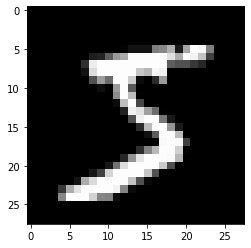

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## RNNs with list/dict inputs, or nested inputs

Nested structures allow implementers to include more information within a single
timestep. For example, a video frame could have audio and video input at the same
time. The data shape in this case could be:

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both coordinates x and y for the
current position of the pen, as well as pressure information. So the data
representation could be:

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

The following code provides an example of how to build a custom RNN cell that accepts
such structured inputs.

### Define a custom cell that support nested input/output

See [Making new Layers & Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)
for details on writing your own layers.

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### Build a RNN model with nested input/output

Let's build a Keras model that uses a `keras.layers.RNN` layer and the custom cell
we just defined.

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### Train the model with randomly generated data

Since there isn't a good candidate dataset for this model, we use random Numpy data for
demonstration.

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

 1/10 [==>...........................] - ETA: 0s - loss: 1.1968 - rnn_1_loss: 0.3269 - rnn_1_1_loss: 0.8700 - rnn_1_accuracy: 0.0625 - rnn_1_1_accuracy: 0.0281

 4/10 [===========>..................] - ETA: 0s - loss: 0.9152 - rnn_1_loss: 0.3203 - rnn_1_1_loss: 0.5949 - rnn_1_accuracy: 0.0703 - rnn_1_1_accuracy: 0.0338

 6/10 [=================>............] - ETA: 0s - loss: 0.8634 - rnn_1_loss: 0.3094 - rnn_1_1_loss: 0.5540 - rnn_1_accuracy: 0.0755 - rnn_1_1_accuracy: 0.0337

 9/10 [==========================>...] - ETA: 0s - loss: 0.7695 - rnn_1_loss: 0.2867 - rnn_1_1_loss: 0.4828 - rnn_1_accuracy: 0.0833 - rnn_1_1_accuracy: 0.0332

10/10 [==============================] - 0s 22ms/step - loss: 0.7499 - rnn_1_loss: 0.2790 - rnn_1_1_loss: 0.4709 - rnn_1_accuracy: 0.0844 - rnn_1_1_accuracy: 0.0336


With the Keras `keras.layers.RNN` layer, You are only expected to define the math
logic for individual step within the sequence, and the `keras.layers.RNN` layer
will handle the sequence iteration for you. It's an incredibly powerful way to quickly
prototype new kinds of RNNs (e.g. a LSTM variant).

For more details, please visit the [API docs](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/).